By: Mohamed Ait Mhamed Belcaid, Graduate Student in Electrical Engineering, Michigan Technological University.


# References

Credit: codes developed in this project have been inspired by the following references:

\[1\] T. Havens, "Data Classification," CS/EE 5841 Machine Learning Lecture notes, College of Computing, Michigan Technological University, Spring 2020.

\[2\] https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

\[3\] https://beckernick.github.io/logistic-regression-from-scratch/

# Part 2: Logistic Regression Classification

## MNIST data:

The following codes are designed to read the .gz files for the MNIST data sets.

In [0]:
# import packages
from __future__ import print_function
import time
import gzip
import struct
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression # used only for comparisson
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn import datasets
# import sklearn


In [2]:
#
"""
# UNCOMMENT IF YOU ARE USING GOOGLE COLAB
# select to upload from local drive: the 4 .gz files for MNIST data
# uncomment the next two lines if you're using Google CoLab
from google.colab import files
uploaded = files.upload()
"""

Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz


In [0]:
# Read MNIST data and labels from .gz files
#
# train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
# train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
# t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
# t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
#
def read_mnist(filename):
    # Based on reference [3]
    # function that reads MNIST's file format into numpy arrays
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
#
# training/validation data
filename       = 'train-images-idx3-ubyte.gz'
trainvalData3D = read_mnist(filename)
# convert 3D ndarrays of data to 2D array by reshaping each datapoint 28x28 to 1x784
# for any 3D ndarray a (l, m, n), use: numpy.reshape(a, (l, m*n))
a              = np.copy(trainvalData3D);
trainvalData   = np.reshape(a, (a.shape[0],a.shape[1]*a.shape[2]))
#
# training/validation labels
filename       = 'train-labels-idx1-ubyte.gz'
trainvalLabels = read_mnist(filename)
#
# testing data
filename       = 't10k-images-idx3-ubyte.gz'
testData3D     = read_mnist(filename)
# convert 3D ndarrays of data to 2D array by reshaping each datapoint 28x28 to 1x784
# for any 3D ndarray a (l, m, n), use: numpy.reshape(a, (l, m*n))
a              = np.copy(testData3D);
testData       = np.reshape(a, (a.shape[0],a.shape[1]*a.shape[2]))
#
# testing labels
filename       = 't10k-labels-idx1-ubyte.gz'
testLabels     = read_mnist(filename)
#

## Implementation:

The main functions implemented for the classifier are presented in the following codes.

In [0]:
def sigmoid(scores):
    sig = 1.0 / (1.0 + np.exp(-scores))
    return sig

In [0]:
def log_likelihood(features, target, weights, lambda_reg):
    # scores
    scores = np.multiply( target, np.dot(features, weights) )
    # log-likelihood with L2-regularization (λ as regularization parameter)
    ll     = (lambda_reg/2) * np.dot(weights, weights) + np.sum( np.log(1 + np.exp(-scores)) )
    return ll

In [0]:
def logistic_regression(features, target, num_iterations, lambda_reg):
    # add first column of ones to account for bias b in weights w
    intercept = np.ones((features.shape[0], 1))
    features  = np.hstack((intercept, features))
    # initialize weights
    weights = np.zeros(features.shape[1])
    # update weights in each iteration t
    for iteration in range(num_iterations):
        # use FIXED learning rate if needed (slower convergence AND higher accuracy)
        # learning_rate = 1e-10 # use num_iterations = 1001
        # use VARIABLE learning rate if needed (faster convergence AND lower accuracy)
        learning_rate = 5e-4 * 1/np.sqrt(iteration+1) # add 1 to account for iteration=0
        # compute scores
        scores              = np.multiply( target, np.dot(features, weights) )
        # compute prediction probabilities
        predictions         = sigmoid(scores)
        # compute gradients with L2-regularization (λ as regularization parameter)
        output_error_signal = np.ones(predictions.shape) - predictions
        inclass_features    = np.multiply(features, target[:, np.newaxis])
        gradient = lambda_reg * weights - np.dot(np.transpose(inclass_features), output_error_signal)
        # update weights
        weights -= learning_rate * gradient
        # Print log-likelihood every half of total number of iterations
        if iteration % np.floor(num_iterations/4) == 0:
            print('iteration: ', iteration, '\t learning rate: ', learning_rate,
                  '\t max. abs. gradient: ', np.amax(np.absolute(gradient)),
                  '\t log-likelihood: ', log_likelihood(features, target, weights, lambda_reg))
    return weights


In [0]:
def runLogisticRegression(num_iterations, lambda_reg):
    # record predictions for each image in testing data using the 10 classifiers
    allpreds   = np.zeros((testLabels.shape[0],10))
    # record weights (add column to include bias/intercept)
    allweights = np.zeros((785,10))
    # define class for digit
    digits  = [0,1,2,3,4,5,6,7,8,9]
    for digit_class in digits:
        #
        print('****************************************************************')
        print('Logistic Regression with L2-regularization where λ = {0}:'.format(lambda_reg))
        print('classifier {0}-versus-rest:'.format(digit_class))
        #
        # STEP 1: re-label data with +1 (in class) and -1 (not in class)
        # Data: copy
        train_features = np.copy(trainvalData)
        test_features  = np.copy(testData)
        # Labels: convert from string to float to allow signed values
        train_labels   = np.copy(trainvalLabels).astype(float)
        test_labels    = np.copy(testLabels).astype(float)
        # if label is NOT digit_class, set train_labels = -1
        # otherwise, set train_labels = 1
        # do similarly for test_labels
        # set all labels NOT equal to digit_class to -1 (i.e. NOT IN CLASS)
        # set all labels equal to digit_class to 1 (i.e. IN CLASS)
        train_labels[train_labels != digit_class] = -1
        train_labels[train_labels == digit_class] = 1
        test_labels[test_labels != digit_class] = -1
        test_labels[test_labels == digit_class] = 1
        #
        # STEP 2: compute weights using training data / labels
        weights = logistic_regression(train_features, train_labels,
                            num_iterations, lambda_reg)
        #
        # STEP 3: evaluate accuracy on testing data
        # using our logistic regression algorithm from scratch:
        final_scores = np.dot(np.hstack((np.ones((test_features.shape[0], 1)),
                                        test_features)), weights)
        preds        = sigmoid(final_scores)
        # record predictions of this classifier for future comparison with other classifiers
        allpreds[:,digit_class]   = np.copy(preds)
        # also record weights of this classifier to show them as images later
        allweights[:,digit_class] = np.copy(weights)
    #
    # STEP 3: evaluate accuracy on testing data (continued)
    # classify each image from testing data
    # for each image, there are 10 prediction probabilities (from each classifier)
    # select label corresponding to highest probabilities among these 10 values
    predictedLabels = np.empty(allpreds.shape[0])
    for i in range(allpreds.shape[0]):
        # prediction for image i using the 10 different classifiers:
        image_preds        = np.copy(allpreds[i,:])
        # argmax is the index of the highest probability; this index is also the predicted label
        ind                = np.unravel_index(np.argmax(image_preds, axis=None), image_preds.shape)
        predictedLabels[i] = ind[0]
        # print('image', i, 'with true label', testLabels[i], 'classified as', ind[0], 'with probability', image_preds[ind])
    # convert predicted labels to integer type
    predictedLabels = predictedLabels.astype(int)
    #
    # confusion matrix
    confusionMatrix = np.zeros((10,10))
    for i in range(testLabels.shape[0]):
        confusionMatrix[testLabels[i],predictedLabels[i]] = confusionMatrix[testLabels[i],predictedLabels[i]] + 1
    # print('confusion matrix:\n',confusionMatrix.astype(int))
    # accuracy for each digit
    # by comparing actual label to corresponding predicted label (row wise)
    accuracy_per_digit = np.zeros(10)
    for i in range(confusionMatrix.shape[0]):
        accuracy_per_digit[i] = confusionMatrix[i,i] / np.sum(confusionMatrix[i,:])
        # print('accuracy for true label ', i, 'is ', 100 * accuracy_per_digit[i], '%')
    # overall accuracy
    correct_overall = 0
    for i in range(confusionMatrix.shape[0]):
        correct_overall += confusionMatrix[i,i] 
    accuracy_overall = correct_overall / np.sum(confusionMatrix)
    # print('overall accuracy for all true labels is ', 100 * accuracy_overall, '%')
    #
    return allweights, confusionMatrix, accuracy_per_digit, accuracy_overall


Run algorithm:

In [ ]:
num_iterations = 201 # 501 # 1001
# regularization parameter
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
accuracy_all = np.zeros(len(lambdas))
for k in range(len(lambdas)):
    lambda_reg               = lambdas[k]
    _, _, _, accuracy_all[k] = runLogisticRegression(num_iterations, lambda_reg)


In [9]:
print('λ values: ',lambdas)
print('log10(λ) values: ',np.log10(lambdas))
print('overall testing accuracy values (in %): ',100 * accuracy_all)

λ values:  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0]
log10(λ) values:  [-5. -4. -3. -2. -1.  0.  1.  2.]
overall testing accuracy values (in %):  [80.41 80.51 84.22 84.21 80.58 84.19 84.54 80.48]


****************************************************************
Plot of overall testing accuracy (in %) vs log10(λ)


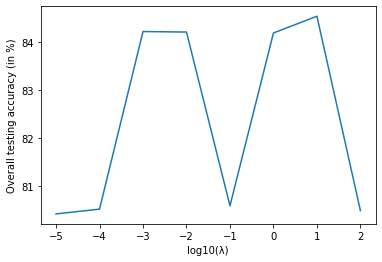

In [10]:
# Plot overall test accuracy versus log10 of regularization values λ
print('****************************************************************')
print('Plot of overall testing accuracy (in %) vs log10(λ)')
if len(lambdas) >= 5:
    plt.plot(np.log10(lambdas), 100 * accuracy_all)
    plt.xticks(np.log10(lambdas))
    plt.xlabel('log10(λ)')
    plt.ylabel('Overall testing accuracy (in %)')
    plt.show()


In [ ]:
# select regularizer value with highest accuracy:
idx         = np.argmax(accuracy_all)  # Only the first occurrence is returned
lambda_best = lambdas[idx]
print('Best regularization value is λ = ', lambda_best)
allweights, confusionMatrix, accuracy_per_digit, accuracy_overall = runLogisticRegression(num_iterations, lambda_best)
# confusion matrix
print('\n')
print('Confusion Matrix:\n',confusionMatrix.astype(int))
# accuracy for each digit
print('\n')
for i in range(confusionMatrix.shape[0]):
    print('Accuracy for True Label ', i, 'is ', 100 * accuracy_per_digit[i], '%')
# overall accuracy
print('\n')
print('Overall Accuracy for all True Labels is ', 100 * accuracy_overall, '%')


In [0]:
def plot_digit(some_digit):
    # From online reference: plot vector as image
    # reshape 784 vector to 28x28
    some_digit_image = some_digit.reshape(28,28)
    # plot as image
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()


(784, 10)
classifier 0-versus-rest:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


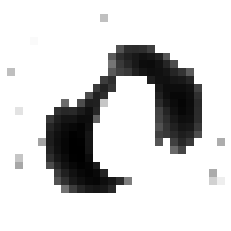

classifier 1-versus-rest:


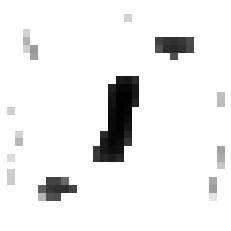

classifier 2-versus-rest:


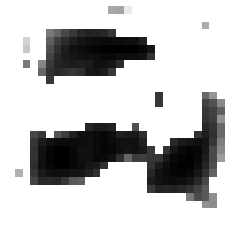

classifier 3-versus-rest:


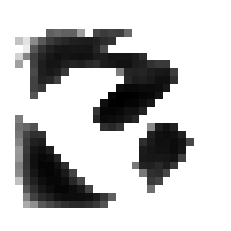

classifier 4-versus-rest:


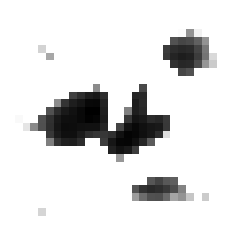

classifier 5-versus-rest:


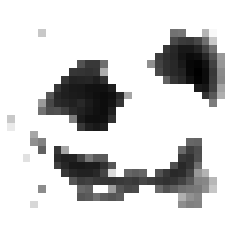

classifier 6-versus-rest:


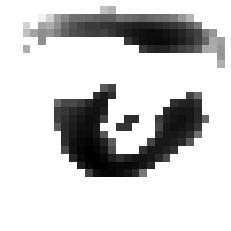

classifier 7-versus-rest:


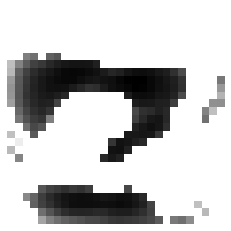

classifier 8-versus-rest:


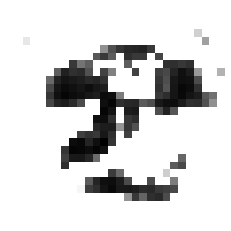

classifier 9-versus-rest:


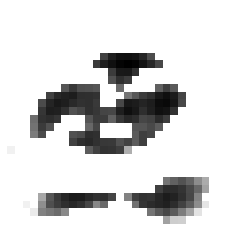

In [13]:
# For each of your 10 trained classifiers, showing an image of the 
# 784 weights (after removing the bias weight) as a 28×28 image.
# delete row 0 (first):
allweights_nobias = np.delete(allweights, 0, axis=0)
print(allweights_nobias.shape)
digits  = [0,1,2,3,4,5,6,7,8,9]
for digit_class in digits:
    print('classifier {0}-versus-rest:'.format(digit_class))
    # get weights vector; reshape to 28x28
    weights_vec = allweights_nobias[:,digit_class]
    # visualization is clearer with the log of weights
    # show as image
    plot_digit(np.log(weights_vec))


## Tests:

For any digit $\# \in \{0,1,2,3,4,5,6,7,8,9\}$, the ‘digit # versus rest’ classifier is trained to give a probability of the digit # versus all other digits; digit # is labeled class +1 and all other digits are labeled class -1. Hence, to classify a test image, the maximum probability from all 10 classifiers is chosen, giving the predicted class of the input image.

The update equation for the regularized logistic regression is obtained by taking the gradient of $\mathcal{L}(\pmb{w})$. This derivation is presented for L2-regularized logistic regression that uses the following **log-likelihood**:

$$\mathcal{L}(\pmb{w}) = \frac{\lambda}{2} ||\pmb{w}||_2^2 + \sum_{i=1}^N log(1+exp(-y_i\pmb{w}^Tx_i)) = \frac{\lambda}{2} \pmb{w}^T \pmb{w} + \sum_{i=1}^N log(1+exp(-y_i\pmb{w}^Tx_i))$$

$$\nabla_{\pmb{w}}\mathcal{L}(\pmb{w}) = \lambda \pmb{w} + \sum_{i=1}^N \frac{1}{1+exp(-y_i\pmb{w}^Tx_i)} \nabla_{\pmb{w}}(1+exp(-y_i\pmb{w}^Tx_i)) = \lambda \pmb{w} + \sum_{i=1}^N \frac{1}{1+exp(-y_i\pmb{w}^Tx_i)} \nabla_{\pmb{w}}(exp(-y_i\pmb{w}^Tx_i))$$

$$= \lambda \pmb{w} + \sum_{i=1}^N \frac{1}{1+exp(-y_i\pmb{w}^Tx_i)} exp(-y_i\pmb{w}^Tx_i) \nabla_{\pmb{w}}(-y_i\pmb{w}^Tx_i) = \lambda \pmb{w} + \sum_{i=1}^N \frac{1}{1+exp(-y_i\pmb{w}^Tx_i)} exp(-y_i\pmb{w}^Tx_i) (-y_i x_i)$$

$$\nabla \mathcal{L}(\pmb{w}) = \lambda \pmb{w} - \sum_{i=1}^N \frac{y_i x_i exp(-y_i\pmb{w}^Tx_i)}{1+exp(-y_i\pmb{w}^Tx_i)} = \lambda \pmb{w} - \sum_{i=1}^N y_i x_i (1 - p(y_i | x_i))$$

with the prediction probability:

$$p(y_i | x_i) = \sigma(y_i\pmb{w}^Tx_i) = \frac{1}{1+exp(-y_i\pmb{w}^Tx_i)}$$

and the gradient descent update equation for L2-regularized logistic regression:

$$\pmb{w}_{t+1}=\pmb{w}_t-\eta_t\nabla\mathcal{L}(\pmb{w}); \quad \eta_t \propto 1/\sqrt{t}$$

A logistic regression classifier with ridge (L2) regularization is developed. This classifier is tested on the MNIST data set by developing 10 classifiers: 0-versus-rest, 1-versus-rest, ... , 9-versus-rest. A small enough variable learning rate is used: $\eta_t = 5.10^{-4}/\sqrt{t}$, with a total number of iterations $t_{max}=200$.

The confusion matrix is shown above, where rows represent true labels (0-9) and columns the predicted labels (0-9). The number of correctly classified digits are along the diagonal of the confusion matrix, which are the dominant majority of classified digits in the testing set.

The accuracy for each digit is shown above. Accuracy for 0 and 1 is > 94% since these two digits have distinct shapes from all other digits. Accuracy drops to 66-75% for digits 9 and 5 since these two digits have shapes that are similar to each other. Other digits have an accuracy around 82-87%.

The overall accuracy is shown above. For the best regularizer $log_{10}=1$, it is equal to 84.54%. Note that $log_{10}(\lambda)$ values: [-5. -4. -3. -2. -1.  0.  1.  2.] correspond to overall testing accuracy values (in %): [80.41 80.51 84.22 84.21 80.58 84.19 84.54 80.48]
Note that values $log_{10}(\lambda)=[-3., -2., 0.,  1.]$ all result in overall accuracy around 84%. The overall test accuracy versus the $log_{10}$ of regularization value is plotted above and confirms this result.

For each of the 10 trained classifiers, an image of the 784 weights (excluding the bias weight) is shown as a $28 \times 28$ image. These images provide insight to how this classifier works: weights w represent the importance of a pixel in the image, and so higher weights are given to pixels that describe the shape of the digit, and lower weights are givens to less important pixels such as background pixels. The image of the weights look very similar to the digit that is being classified.